# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In this post, I will analyze the Starbucks Dataset using the CRISP-DM Process. I will aim to answer a few business questions, by exploring the dataset using Data Visualization, and Modeling. The questions that I am interested in exploring are:

1. How does Gender influence how much someone spends at Starbucks? Do men spend more than women, or the other way around?
2. How many people view and complete offers? And how many people complete offers without opening them first?
3. What are the attributes that most contribute to someone's spending habits at Starbucks?

These questions help us with a *Business Understanding* of the domain.

Let's start by first importing the required packages, and loading the datasets.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split;
from sklearn.preprocessing import StandardScaler;
from sklearn.svm import SVR;
from sklearn.model_selection import GridSearchCV;
from sklearn.metrics import r2_score;
from sklearn.ensemble import RandomForestRegressor;

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Exploring the Data

We'll look at these datasets by printing out the first few rows of each.

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


We'll now visualize these datasets by plotting correlation plots in Portfolio and Profile.

C:\Users\agusa\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\agusa\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


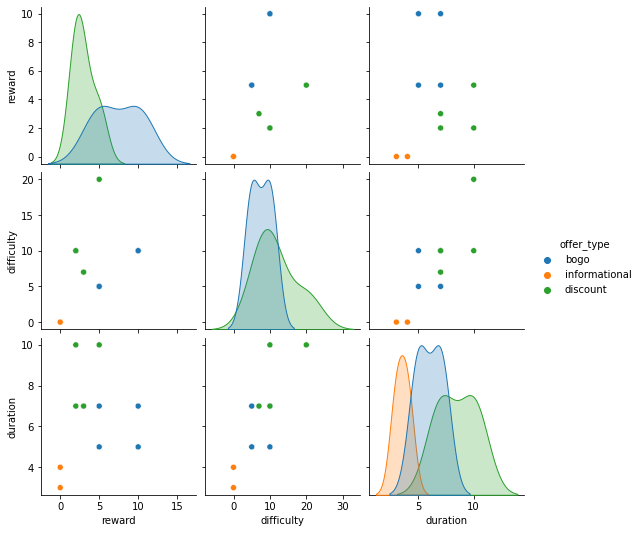

In [5]:
sns.pairplot(portfolio, hue='offer_type')

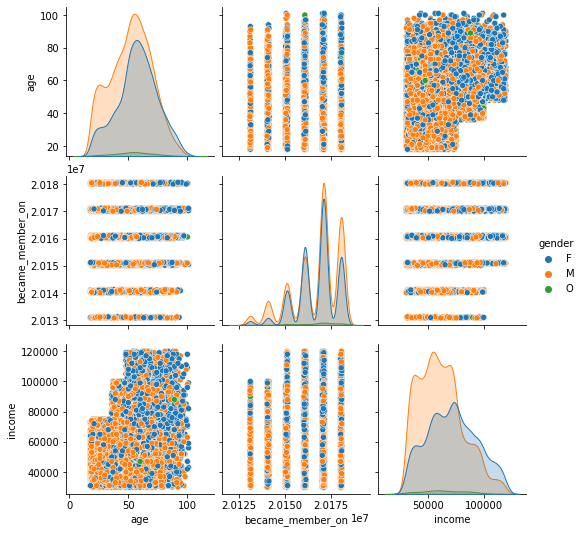

In [6]:
sns.pairplot(profile.dropna(), hue='gender')

There is a lot of data for the Profiles, and we can see some interesting trends from it. For instance, in terms of **age**, most female purchasers tend to be younger than most male purchasers.

To explore the Transcript dataset, I'll look at the distribution of the types of offers that people respond to. I will plot the channels corresponding to the offers, and the type of offer they are.

In [7]:
# Replace missing offer id's with 0
all_offers = transcript.value.apply(lambda x: x['offer id'] if 'offer id' in x else 0).values
all_offers = all_offers[all_offers != 0];
portfolio_group = portfolio.groupby('id')[['offer_type', 'channels']];

# Flatten the channel names into an array
all_channels = [portfolio_group.get_group(ide).values[0][1] for ide in all_offers];
all_channels = [row for subrow in all_channels for row in subrow]

# Flatten the offer types into an array
all_types = [portfolio_group.get_group(ide).values[0][0] for ide in all_offers];
del all_offers, portfolio_group

C:\Users\agusa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\agusa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

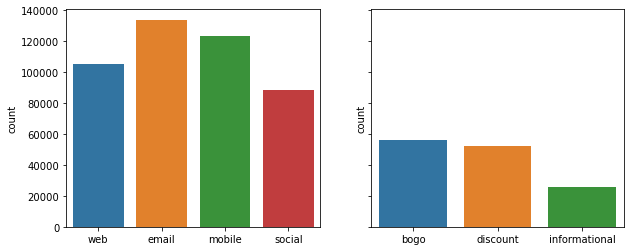

In [8]:
plt.rcParams["figure.figsize"] = (10,4)

fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True)

sns.countplot(all_channels, ax=ax1)
sns.countplot(all_types, ax=ax2)

We see with these distributions that the most offers are sent through **Email** and **Mobile**. **Informational** offers are much more uncommon than the other types of offers as well. I'd like to explore the data further by filtering out only transactions that have been *viewed* and *completed*.

In [9]:
del all_types, all_channels;

### Preparing the data

As we can already see through the initial exploration, there are a lot of areas that need to be cleaned. This will include formatting the text columns, and removing missing values.

We'll start with the **Portfolio** dataset. We see that **channels** are grouped as list values. I will separate the individual values and dummy-fy them. The same will be done for **offer types**. We'll then drop the original columns and append the newer one-hot encoded columns.

In [10]:
# Dummy-fy channel attributes
portfolio_channels = portfolio['channels'].apply(lambda x: ' '.join(x)).str.get_dummies(' ');
portfolio_channels.columns = ['channel_' + col for col in portfolio_channels.columns];

# Dummy-fy offer type attributes
portfolio_offertype = portfolio['offer_type'].str.get_dummies()
portfolio_offertype.columns = ['offer_' + col for col in portfolio_offertype.columns];

In [11]:
# Add dummy columns and drop existing
portfolio = pd.concat([portfolio, portfolio_channels, portfolio_offertype], axis=1);
portfolio = portfolio.drop(['channels', 'offer_type'], axis=1);
portfolio.head()

,reward,difficulty,duration,id,channel_email,channel_mobile,channel_social,channel_web,offer_bogo,offer_discount,offer_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0


In [12]:
del portfolio_channels, portfolio_offertype

In [13]:
portfolio.isna().sum().sum()

0

The above sample shows our final cleaned **Portfolio** dataset. The above call also shows that there are no missing values to be removed.

Next, we look at the **Profile** dataset. Let's start by looking at missing value counts, and dropping these rows.

In [14]:
print('# missing values of income, gender:')
profile['income'].isna().sum(), profile['gender'].isna().sum()

# missing values of income, gender:


(2175, 2175)

In [15]:
profile = profile.dropna(axis=0, subset=['gender', 'income']);

The **Profile** dataset also has a column for membership data, **became_member_on**. I will separate out the date strings into *Year*, *Month*, and *Day*, and keep them as integer values. For **gender**, we will dummy-fy the values into separate one-hot-encodings.

In [16]:
profile_gender = profile['gender'].str.get_dummies()
profile_gender.columns = ['gender_' + col for col in profile_gender.columns];

In [17]:
# Separate date attributes into year, month, and day, converting to integers.
profile_date = profile['became_member_on'];

profile_year = profile_date.apply(lambda d: str(d)).str[0:4].astype('int').rename('member_year');
profile_month = profile_date.apply(lambda d: str(d)).str[4:6].astype('int').rename('member_month');
profile_day = profile_date.apply(lambda d: str(d)).str[6:8].astype('int').rename('member_day');

In [18]:
profile = pd.concat([profile, profile_gender, profile_year, profile_month, profile_day], axis=1);

In [19]:
profile = profile.drop(['became_member_on', 'gender'], axis=1);

In [20]:
del profile_gender, profile_year, profile_month, profile_day

In [21]:
profile.head()

,age,id,income,gender_F,gender_M,gender_O,member_year,member_month,member_day
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,2017,7,15
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,2017,5,9
5,68,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,2018,4,26
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,2018,2,9
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,2017,11,11


The **Transcript** dataset is bigger and has more required cleaning. The column **value** is stored as a dictionary. The values in the dictionaries are inconsistent, with both `offer_id` and `offer id` stored. Once we clean those, they can be converted into columns. The **event** column will also be dummy-fied, and column names standardized.

In [22]:
transcript_event = transcript['event'].str.get_dummies();
transcript_event.columns = ['event_' + '_'.join(col.split(' ')) for col in transcript_event.columns];

In [23]:
# standardize "offer id" column names
def transcript_value_clean(x_dict):
    if 'offer id' in x_dict:
        x_dict['offer_id'] = x_dict['offer id'];
        del x_dict['offer id'];
    return x_dict;

transcript_values = transcript['value'].apply(lambda x: transcript_value_clean(x));
transcript_values = pd.DataFrame(list(transcript_values.values));

Amount values are stored in both **reward** and **amount** columns, and they distinguish different types of transactions. Instead of having both, we will merge both into a single column, and use new columns *is_reward* and *is_amount* for distinguishing them. Finally, if there is an **offer_id** associated with a transaction, *has_offer* will store it, and null values will be replaced with a 0.

In [24]:
transcript_values['is_reward'] = transcript_values['reward'].apply(lambda x: int(not np.isnan(x)));

In [25]:
# merge amount and reward columns
transcript_values['is_amount'] = transcript_values['amount'].apply(lambda x: int(not np.isnan(x)));
transcript_values['amount'] = transcript_values[['amount', 'reward']].apply(lambda x: x[0] if np.isnan(x[1]) else x[1], axis=1)

In [26]:
# filling null offer ids with "0"
transcript_values['has_offer'] = transcript_values['offer_id'].apply(lambda x: int(not pd.isna(x)));
transcript_values['offer_id'] = transcript_values['offer_id'].apply(lambda x: '0' if pd.isna(x) else x);

In [27]:
transcript = pd.concat([transcript, transcript_values, transcript_event], axis=1);

In [28]:
transcript = transcript.drop(['value', 'event', 'reward'], axis=1);

In [29]:
del transcript_value_clean, transcript_values, transcript_event

In [30]:
transcript.head()

,person,time,offer_id,amount,is_reward,is_amount,has_offer,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,0,1,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,1,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,0,0,1,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,0,1,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,0,1,0,1,0,0


The final **Portfolio**, **Profile**, and **Transcript** datasets are all cleaned, and can be used for further exploration. We'll now create some new datasets from these. These will be

- Transactions Only - Store only transactions, not associated with an offer, along with demographic data on the users.

- Transcript by Group - Store transactions by grouping them by their offer, and the person it was sent to.

In [31]:
transcript_profile = pd.merge(transcript, profile, left_on='person', right_on='id')

In [32]:
# keep only records of actual transactions, and keep integer columns
transaction_data_only = transcript_profile[transcript_profile.event_transaction == 1];
transaction_data_only = transaction_data_only.select_dtypes(exclude=['object']);

# separate into male and female dataframes
transaction_data_f = transaction_data_only[transaction_data_only.gender_F == 1]
transaction_data_m = transaction_data_only[transaction_data_only.gender_M == 1]

transaction_data_only.head()

,time,amount,is_reward,is_amount,has_offer,event_offer_completed,event_offer_received,event_offer_viewed,event_transaction,age,income,gender_F,gender_M,gender_O,member_year,member_month,member_day
2,132,19.89,0,1,0,0,0,0,1,75,100000.0,1,0,0,2017,5,9
4,144,17.78,0,1,0,0,0,0,1,75,100000.0,1,0,0,2017,5,9
7,222,19.67,0,1,0,0,0,0,1,75,100000.0,1,0,0,2017,5,9
8,240,29.72,0,1,0,0,0,0,1,75,100000.0,1,0,0,2017,5,9
9,378,23.93,0,1,0,0,0,0,1,75,100000.0,1,0,0,2017,5,9


C:\Users\agusa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


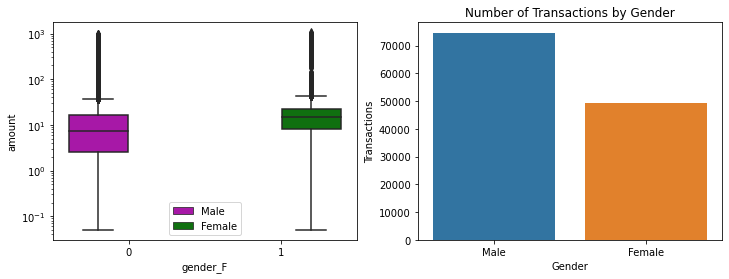

In [33]:
plt.rcParams["figure.figsize"] = (12,4)

fig, (ax1, ax2) = plt.subplots(ncols = 2)

# plotting a Box Plot of amounts by gender
g = sns.boxplot(x="gender_F", y="amount",
            hue="gender_F", palette=["m", "g"],
            data=transaction_data_only, ax=ax1)

# set a log Y scale
g.set_yscale('log')
g.legend().set_title('Gender')
for t, l in zip(g.legend().texts, ['Male', 'Female']): t.set_text(l)

# plot title and axis
plt.title('Amount spent on transactions by Gender')
plt.xlabel('Gender')
plt.ylabel('Amount')
plt.xticks([[]])

# plotting a Bar Plot of number of transactions by gender
h = sns.countplot(transaction_data_only['gender_F'], ax=ax2)

# plot title and axis
plt.title('Number of Transactions by Gender')
plt.xlabel('Gender')
plt.ylabel('Transactions')

plt.xticks([0, 1], ['Male', 'Female'])

# Create a new DataFrame of stat details on required attributes
description_columns = ['amount', 'age', 'income']
description_labels = [cat + '_' + gen for cat in ['Male', 'Female'] for gen in description_columns]
reorder_columns = [gen + '_' + cat for cat in description_columns for gen in ['Male', 'Female']]

# Separate into stats from Female and Male transactions
description = pd.concat([transaction_data_m[['amount', 'age', 'income']].describe(), 
           transaction_data_f[['amount', 'age', 'income']].describe()], axis=1);
description.columns = description_labels;

plt.show()

In [34]:
description[reorder_columns]

,Male_amount,Female_amount,Male_age,Female_age,Male_income,Female_income
count,72794.000000,49382.000000,72794.000000,49382.000000,72794.000000,49382.000000
mean,11.606600,17.490077,50.725650,55.637986,58491.317966,66813.960552
std,28.964542,35.342611,17.755604,17.776608,19048.170156,21965.016643
min,0.050000,0.050000,18.000000,18.000000,30000.000000,30000.000000
25%,2.570000,7.970000,37.000000,43.000000,43000.000000,51000.000000
50%,7.050000,15.000000,52.000000,56.000000,56000.000000,65000.000000
75%,16.220000,22.120000,64.000000,68.000000,70000.000000,82000.000000
max,977.780000,1062.280000,100.000000,101.000000,120000.000000,120000.000000


The above three charts answer our questions about **Gender**. We see in the first plot that *Women* spend more on transactions then *Men* do. The interesting thing in the second chart is that it shows that there are a lot more records of purchases by men than those by women.

The final chart (table)  gives more detailed statistics on **Amount**, **Age**, and **Income** separated by **Gender**. It shows that *Women* clearly spend more than *Men* do, with higher mean and deviation. Contrary to the early plot on raw data, we see that the **age** of most spenders is similar for both men and women. Finally, the biggest disparity we see is in **Income**. Higher mean and 25/50/70 percentage quantile shows that the average Female spender earns more than the average Male spender.

***This answers our first question on the influence of gender of purchases. Women spend more at Starbucks then Men do, with an average difference of about 6 dollars per purchase***.

### Modeling the data

With our cleaned data, we can now use Supervised Models to try to predict price. Because **price** is a continous variable, we will need to use a regression model. First, we'll need to separate the data into X and Y.

In [39]:
# Time is relative and will likely not be useful. Amount will be separated into the Y column.

data_x = transaction_data_only.drop(['amount', 'time'], axis=1);
data_y = transaction_data_only['amount'];

We'll now use a Scaler function to normalize the attributes.

In [40]:
scaler = StandardScaler();
data_x = scaler.fit_transform(data_x);

In [41]:
data_x.shape, data_y.shape

((123957, 15), (123957,))

And finally, separate the X and Y into a Train/Test split.

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.33);

In [43]:
X_train.shape, X_test.shape

((83051, 15), (40906, 15))

For modeling, let's start by first using a **Support Vector Machine (SVM)** to fit a model to the data. I will use a Polynomial Regression model. The metric I decided to use is a **R2** score, which works well on continious output.

In [ ]:
sv_model = SVR(kernel='poly', degree=7);
sv_model.fit(X_train, y_train);
print('SVR model trained on 7-degree poly kernel')

In [ ]:
y_preds_svr = sv_model.predict(X_test);
print('SVR Model R2 score: ' , r2_score(y_test, y_preds_svr))

Although the SVM provided good results, we cannot view feature importance because the kernel is non-linear. Feature importance is useful for us because it will help us understand which attributes most contribute to a predicted label. Let's use a different model for this, such as a **Random Forest**.

In [ ]:


rf_model = RandomForestRegressor(n_estimators=100, max_depth=20, max_features=15, min_samples_split=5);
rf_model.fit(X_train, y_train);
print('RF Model trained with 10 estimators'

In [ ]:


y_preds_rf = rf_model.predict(X_test);
print('RF Model R2 score: ' , r2_score(y_test, y_preds_rf))

The R2 Score is not as good as that obtained with the SVM, so we should try to tune the model to find parameters that provide the best results. For this, we can use a **Grid Search**. The parameters we will tune are

- Number of Estimators, between *10, 50, and 100*
- Maximum Depth of a tree, between *5, 10, 30, and 80*
- Maximum Number of Features in a tree, between *1, 3, 8, and 15*
- Minimum Samples to split on, between *3, 5, 10, 30, 50, and 100*

In [ ]:
params = {'n_estimators' : [10, 50, 100], 'max_depth' : [5, 10, 30, 80], \
          'max_features': [1, 3, 8, 15], 'min_samples_split': [3, 5, 10, 30, 50, 100]}

g_rfm = RandomForestRegressor(random_state=1024);
g_src = GridSearchCV(g_rfm, params, verbose=10, cv=5, scoring='r2');

In [ ]:
g_src.fit(X_train, y_train)

We can use these obtained parameters to train a Tuned model.

In [ ]:
tuned_rf_model = RandomForestRegressor(max_depth=30, max_features=3, min_samples_split=100, n_estimators=100);

In [ ]:
tuned_rf_model.fit(X_train, y_train);

In [ ]:
y_preds_tuned = tuned_rf_model.predict(X_test);

In [ ]:
tuned_rf_model.fit(X_train, y_train);

In [ ]:
y_preds_tuned = tuned_rf_model.predict(X_test);

In [ ]:
r2_score(y_test, y_preds_tuned)

### Results

Our final results on the different trained models are:

- 0.0791369487837 with *SVM Regressor*
- -0.0823391370849 with *Default Random Forest Regressor*
- 0.069935792705576483 with *Tuned Random Forest Regressor*

The final **R2** score is better than that obtained with a SVM and with the default Random Forest. There is not a lot of difference between the results of the SVM and Random Forest, and our Grid Search shows that the SVM could be tuned to obtain better results as well.

With Random Forest, we can look at Feature Importance of the attributes that were used to train the model.

In [ ]:
pd.DataFrame(list(zip(transaction_data_only.columns[2:], tuned_rf_model.feature_importances_)), columns=['Attribute', 'Feature Importance']).sort_values(by='Feature Importance', ascending=False)

To predict **price**, it's shown that **income** and **age** are the highest contributors. Surprisingly, **gender** is not as important, although we previously saw some correlation in them. Our boolean attributes are all set to 0, as they should be because the values will be the same for all rows.

***It answers our 3rd question, on which attributes most influence price. Income and Age are most likely to influence how much someone spends at Starbucks.***

#### *Improving the work*

We obtained good results with our model after tuning it with a Random Forest. However, there are some areas that could use improvement. The areas I would like to try to work on as an update to this work are:

1. Instead of relying only on Random Forests, we should compare them against a different model as well. I did use a SVM for an initial benchmark, and it showed promising results with default parameters. This model should have been fine tuned using a Grid Search, to try out different types of kernels, both polynomial and RBF. A non-linear kernel makes more sense for this type of data because there are a lot of numerical attributes.

2. We can make the Status value of auser's response to an offer more granular. The values we obtained are weather a user has viewed, or not viewed an offer, while completing it. There is more information that is availabile in the transcript, such as if the offer was not completed at all, but started. The number of transactions related to an offer could be binned and also separated into individual columns.

2. We could also look at the value of status and see how different demographics relate to it. This could be done by using a supervised learning model to try to train on learning the Status value. To train such a model, we have a lot of available data, because we would be using the transcript records, which would be coupled with information from both profile (demographics) and portfolio (offer details).

### Deploying

The code in the Jupyter Notebook will be posted on GitHub, with a ReadMe file to provide information on how to run the code locally.

In our Data Analysis, we answered three questions that we set out to explore with the Starbucks Transactions dataset.

1. Gender does influence how much a person spends at Starbucks. While Men tend to have more purchases, Women tend to make more expensive purchases. On average, women spend around $6 more per purchase at Starbucks.

2. A significant portion of members do view and complete offers at Starbucks. Based on the dataset, 25% of individuals actually receive, view, and complete the offers by making purchases associated with the offer. Furthermore, 10% of individuals complete offers without actually viewing them first, completing them unintentionally.

3. The attributes that most contribute to how much someone spends at Starbucks are Income and Age. While there are other contributing factors, such as Gender (as we saw previously), Income is the highest influencer with over 55% importance when trying to predict the price of a coffee.

These are very interesting findings, and with the data we cleaned and processed, we can use them to look at many other trends. With this data, 

*How would YOU use it to answer your own questions about Starbucks Purchases?*